In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

In [19]:
molclr = pd.read_csv("../molclr_classifcation_res.csv")

In [20]:
molclr["accuracy"] = molclr["acc"]

In [21]:
molclr_grouped = (
    molclr[molclr["name"] == "Lipo"].groupby(["classes", "num_size"]).agg(["mean", "std", sem])
)

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_59347/851037576.py:2: FutureWarning: ['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  molclr[molclr["name"] == "Lipo"].groupby(["classes", "num_size"]).agg(["mean", "std", sem])


In [22]:
molclr_grouped

Unnamed: 0                             acc            \
                        mean        std        sem      mean       std   
classes num_size                                                         
2       10         88.000000  96.166522  68.000000  0.486236  0.022085   
        50         29.000000  36.769553  26.000000  0.589508  0.019121   
        100       148.000000  50.911688  36.000000  0.608116  0.007861   
        200        83.500000   0.707107   0.500000  0.688935  0.014567   
        500       101.000000  82.024387  58.000000  0.738027  0.009603   
5       10        112.545455  54.838606  16.534462  0.678560  0.002746   
        50         82.090909  48.260656  14.551135  0.693967  0.006538   
        100       112.545455  52.083325  15.703713  0.701410  0.008213   
        200       115.818182  48.604152  14.654703  0.730472  0.010692   
        500       101.000000  81.256384  24.499722  0.758685  0.007934   

                            f1_macro                      f1_micro            \
                       sem      mean       std       sem      mean       std   
classes num_size                                                               
2       10        0.015617  0.429205  0.037486  0.026507  0.486236  0.022085   
        50        0.013521  0.566874  0.033005  0.023338  0.589508  0.019121   
        100       0.005559  0.597157  0.003612  0.002554  0.608116  0.007861   
        200       0.010300  0.687792  0.015753  0.011139  0.688935  0.014567   
        500       0.006791  0.737843  0.009506  0.006722  0.738027  0.009603   
5       10        0.000828  0.158932  0.019808  0.005972  0.196400  0.006866   
        50        0.001971  0.217375  0.020639  0.006223  0.234918  0.016344   
        100       0.002476  0.225626  0.033707  0.010163  0.253525  0.020533   
        200       0.003224  0.321727  0.024835  0.007488  0.326181  0.026731   
        500       0.002392  0.390260  0.018058  0.005445  0.396712  0.019835   

                            accuracy                      
                       sem      mean       std       sem  
classes num_size                                          
2       10        0.015617  0.486236  0.022085  0.015617  
        50        0.013521  0.589508  0.019121  0.013521  
        100       0.005559  0.608116  0.007861  0.005559  
        200       0.010300  0.688935  0.014567  0.010300  
        500       0.006791  0.738027  0.009603  0.006791  
5       10        0.002070  0.678560  0.002746  0.000828  
        50        0.004928  0.693967  0.006538  0.001971  
        100       0.006191  0.701410  0.008213  0.002476  
        200       0.008060  0.730472  0.010692  0.003224  
        500       0.005980  0.758685  0.007934  0.002392

### load ngram results

In [44]:
n_gram_baseline = glob("ngram_baseline/*.pkl")
n_gram_baseline_results = []

for f in n_gram_baseline:
    n_gram_baseline_results.append(load_pickle(f))

n_gram_baseline_results = pd.DataFrame(n_gram_baseline_results)

n_gram_baseline_results_grouped = (
    n_gram_baseline_results[
        ["num_classes", "representation", "train_size", "accuracy", "f1_micro", "f1_macro", "kappa"]
    ]
    .groupby(["num_classes", "representation", "train_size"])
    .agg(["mean", "std", sem])
)

## Load results

In [45]:
all_out = glob("out/**/*.pkl")

In [46]:
all_out = [load_pickle(p) for p in all_out]

In [47]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [48]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [49]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(
    ["mean", "std", sem, "count"]
)

In [50]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [51]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [52]:
grouped_res.loc[2, :]

frac_valid                            accuracy  \
                                mean       std       sem count      mean   
representation train_size                                                  
inchi          10           1.000000  0.000000  0.000000     6  0.506000   
               50           1.000000  0.000000  0.000000     6  0.577333   
               100          1.000000  0.000000  0.000000     6  0.570000   
               200          1.000000  0.000000  0.000000     2  0.616000   
               500          1.000000  0.000000  0.000000     3  0.644000   
iupac_name     10           1.000000  0.000000  0.000000     6  0.502667   
               50           1.000000  0.000000  0.000000     6  0.557333   
               100          1.000000  0.000000  0.000000     5  0.550400   
               200          1.000000  0.000000  0.000000     2  0.614000   
               500          1.000000  0.000000  0.000000     3  0.676000   
selfies        10           0.996667  0.004676  0.001909     6  0.524461   
               50           1.000000  0.000000  0.000000     6  0.552000   
               100          1.000000  0.000000  0.000000     5  0.556000   
               200          1.000000  0.000000  0.000000     2  0.594000   
               500          1.000000  0.000000  0.000000     3  0.648000   
smiles         10           1.000000  0.000000  0.000000     7  0.510857   
               50           1.000000  0.000000  0.000000     6  0.569333   
               100          1.000000  0.000000  0.000000     6  0.597333   
               200          1.000000  0.000000  0.000000     3  0.617333   
               500          1.000000  0.000000  0.000000     3  0.678667   

                                                     f1_macro            \
                                std       sem count      mean       std   
representation train_size                                                 
inchi          10          0.068106  0.027804     6  0.498597  0.071371   
               50          0.023956  0.009780     6  0.575866  0.023205   
               100         0.034012  0.013885     6  0.564257  0.032176   
               200         0.045255  0.032000     2  0.608373  0.044268   
               500         0.022271  0.012858     3  0.643194  0.022063   
iupac_name     10          0.037580  0.015342     6  0.441076  0.073295   
               50          0.027674  0.011298     6  0.554577  0.029686   
               100         0.030672  0.013717     5  0.549739  0.030767   
               200         0.014142  0.010000     2  0.612223  0.011709   
               500         0.030199  0.017436     3  0.675774  0.029943   
selfies        10          0.042763  0.017458     6  0.477123  0.061329   
               50          0.016589  0.006772     6  0.545933  0.023938   
               100         0.061188  0.027364     5  0.544762  0.071155   
               200         0.031113  0.022000     2  0.593722  0.031505   
               500         0.010583  0.006110     3  0.646837  0.009708   
smiles         10          0.048974  0.018511     7  0.497102  0.045562   
               50          0.051702  0.021107     6  0.565489  0.053350   
               100         0.041621  0.016992     6  0.595960  0.041784   
               200         0.052205  0.030140     3  0.615638  0.052925   
               500         0.036295  0.020955     3  0.677772  0.037246   

                                           f1_micro                            \
                                sem count      mean       std       sem count   
representation train_size                                                       
inchi          10          0.029137     6  0.506000  0.068106  0.027804     6   
               50          0.009473     6  0.577333  0.023956  0.009780     6   
               100         0.013136     6  0.570000  0.034012  0.013885     6   
               200         0.031302     2  0.616000  0.045255  0.

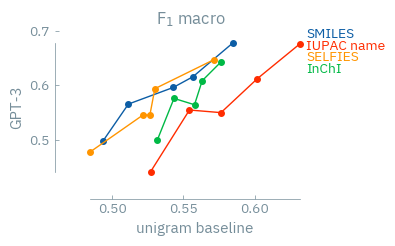

In [53]:
fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

for representation, rn in [
    ("smiles", "SMILES"),
    ("inchi", "InChI"),
    ("selfies", "SELFIES"),
    ("iupac_name", "IUPAC name"),
]:
    ax.plot(
        n_gram_baseline_results_grouped.loc[2, representation, :]["f1_macro"]["mean"],
        grouped_res.loc[2, representation, :]["f1_macro"]["mean"],
        label=rn,
        marker="o",
        markersize=4,
    )

matplotx.line_labels(ax)

range_frame(
    ax,
    n_gram_baseline_results_grouped.loc[2, :, :]["f1_macro"]["mean"].values.reshape(-1, 1),
    grouped_res.loc[2, :, :]["f1_macro"]["mean"].values.reshape(-1, 1),
)

ax.set_xlabel("unigram baseline")
ax.set_ylabel("GPT-3")

fig.suptitle(r"F$_1$ macro")

fig.savefig("lipophilicity_unigram_gpt_corr.pdf", bbox_inches="tight")

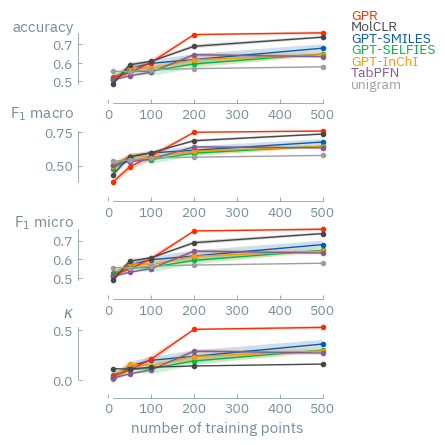

In [72]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, "smiles", :].index,
        grouped_res.loc[2, "smiles", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "smiles", :].index,
        grouped_res.loc[2, "smiles", :][metric]["mean"]
        - grouped_res.loc[2, "smiles", :][metric]["sem"],
        grouped_res.loc[2, "smiles", :][metric]["mean"]
        + grouped_res.loc[2, "smiles", :][metric]["sem"],
        alpha=0.2,
    )

    if metric != "kappa":
        range_frame(
            ax[i],
            grouped_res.loc[2, "smiles", :].index,
            np.stack(
                [
                    grouped_res.loc[2, "smiles", :][metric]["mean"],
                    grouped_res.loc[2, "selfies", :][metric]["mean"],
                    grouped_res.loc[2, "inchi", :][metric]["mean"],
                    grouped_xgboost_res.loc[2, :][metric]["mean"],
                    grouped_tabpfn_res.loc[2, :][metric]["mean"],
                    molclr_grouped.loc[2, :][metric]["mean"],
                ]
            ).flatten(),
        )
    else:
        range_frame(
            ax[i],
            grouped_res.loc[2, "smiles", :].index,
            np.stack(
                [
                    grouped_res.loc[2, "smiles", :][metric]["mean"],
                    grouped_res.loc[2, "selfies", :][metric]["mean"],
                    grouped_res.loc[2, "inchi", :][metric]["mean"],
                    grouped_xgboost_res.loc[2, :][metric]["mean"],
                    grouped_tabpfn_res.loc[2, :][metric]["mean"],
                ]
            ).flatten(),
        )

    ax[i].plot(
        grouped_res.loc[2, "selfies", :].index,
        grouped_res.loc[2, "selfies", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "selfies", :].index,
        grouped_res.loc[2, "selfies", :][metric]["mean"]
        - grouped_res.loc[2, "selfies", :][metric]["sem"],
        grouped_res.loc[2, "selfies", :][metric]["mean"]
        + grouped_res.loc[2, "selfies", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, "inchi", :].index,
        grouped_res.loc[2, "inchi", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "inchi", :].index,
        grouped_res.loc[2, "inchi", :][metric]["mean"]
        - grouped_res.loc[2, "inchi", :][metric]["sem"],
        grouped_res.loc[2, "inchi", :][metric]["mean"]
        + grouped_res.loc[2, "inchi", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        - grouped_xgboost_res.loc[2, :][metric]["sem"],
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        + grouped_xgboost_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"] - grouped_tabpfn_res.loc[2, :][metric]["sem"],
        grouped_tabpfn_res.loc[2, :][metric]["mean"] + grouped_tabpfn_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    if metric != "kappa":
        ax[i].plot(
            molclr_grouped.loc[2, :].index,
            molclr_grouped.loc[2, :][metric]["mean"],
            label="MolCLR",
            marker="o",
        )
        ax[i].fill_between(
            molclr_grouped.loc[2, :].index,
            molclr_grouped.loc[2, :][metric]["mean"] - molclr_grouped.loc[2, :][metric]["sem"],
            molclr_grouped.loc[2, :][metric]["mean"] + molclr_grouped.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    ax[i].plot(
        n_gram_baseline_results_grouped.loc[2, "inchi", :].index,
        n_gram_baseline_results_grouped.loc[2, "inchi", :][metric]["mean"],
        marker="o",
        label="unigram",
    )
ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("lipophilicity-classification_results_binary.pdf", bbox_inches="tight")

In [75]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[1],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 20

3.4305303028790783

In [74]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        n_gram_baseline_results_grouped.loc[2, "inchi", :].index,
        n_gram_baseline_results_grouped.loc[2, "inchi", :]["f1_macro"]["mean"],
    )[0],
) / 10

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c


0.7422978356216958

In [62]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.9685831107527777

In [63]:
find_learning_curve_intersection(
    grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        molclr_grouped.loc[2, :].index,
        molclr_grouped.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

1.3848844758160728

In [64]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, "inchi", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[2, :].index,
                grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, "inchi", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, "inchi", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[2, :].index,
                grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [65]:
from gptchem.evaluator import add_kappa_vlines, get_kappa_intersections

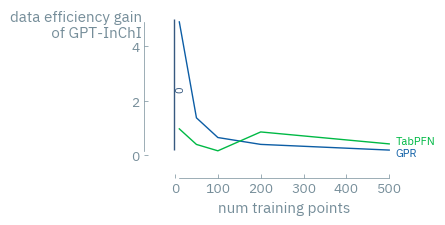

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(grouped_res.loc[2, "inchi", :].index, intersections, label="GPR")
ax.plot(grouped_res.loc[2, "inchi", :].index, intersections_tabpfn, label="TabPFN")
matplotx.line_labels(fontsize=8)
add_kappa_vlines(
    grouped_res.loc[2, "inchi", :]["kappa"].index,
    grouped_res.loc[2, "inchi", :]["kappa"]["mean"],
    low=-5,
    ymax=5,
)
ylabel_top("data efficiency gain\n  of GPT-InChI", x_pad=0.045, y_pad=-0.3)
ax.set_xlabel("num training points", labelpad=4)
range_frame(
    ax,
    grouped_res.loc[2, "inchi", :]["kappa"].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)
plt.savefig("lipophilicity-binary-data-efficiency.pdf", bbox_inches="tight")

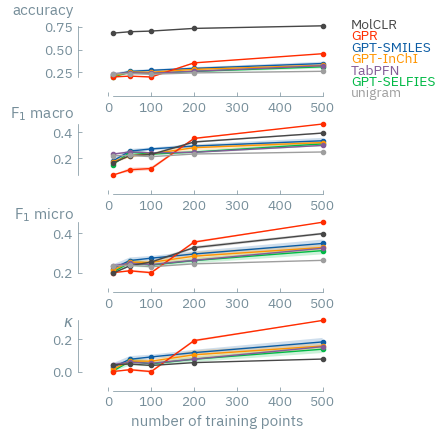

In [71]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, "smiles", :].index,
        grouped_res.loc[5, "smiles", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "smiles", :].index,
        grouped_res.loc[5, "smiles", :][metric]["mean"]
        - grouped_res.loc[5, "smiles", :][metric]["sem"],
        grouped_res.loc[5, "smiles", :][metric]["mean"]
        + grouped_res.loc[5, "smiles", :][metric]["sem"],
        alpha=0.2,
    )

    if metric != "kappa":
        range_frame(
            ax[i],
            grouped_res.loc[5, "smiles", :].index,
            np.stack(
                [
                    grouped_res.loc[5, "smiles", :][metric]["mean"],
                    grouped_res.loc[5, "selfies", :][metric]["mean"],
                    grouped_res.loc[5, "inchi", :][metric]["mean"],
                    grouped_xgboost_res.loc[5, :][metric]["mean"],
                    grouped_tabpfn_res.loc[5, :][metric]["mean"],
                    molclr_grouped.loc[5, :][metric]["mean"],
                ]
            ).flatten(),
        )
    else:
        range_frame(
            ax[i],
            grouped_res.loc[5, "smiles", :].index,
            np.stack(
                [
                    grouped_res.loc[5, "smiles", :][metric]["mean"],
                    grouped_res.loc[5, "selfies", :][metric]["mean"],
                    grouped_res.loc[5, "inchi", :][metric]["mean"],
                    grouped_xgboost_res.loc[5, :][metric]["mean"],
                    grouped_tabpfn_res.loc[5, :][metric]["mean"],
                ]
            ).flatten(),
        )

    ax[i].plot(
        grouped_res.loc[5, "selfies", :].index,
        grouped_res.loc[5, "selfies", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "selfies", :].index,
        grouped_res.loc[5, "selfies", :][metric]["mean"]
        - grouped_res.loc[5, "selfies", :][metric]["sem"],
        grouped_res.loc[5, "selfies", :][metric]["mean"]
        + grouped_res.loc[5, "selfies", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, "inchi", :].index,
        grouped_res.loc[5, "inchi", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "inchi", :].index,
        grouped_res.loc[5, "inchi", :][metric]["mean"]
        - grouped_res.loc[5, "inchi", :][metric]["sem"],
        grouped_res.loc[5, "inchi", :][metric]["mean"]
        + grouped_res.loc[5, "inchi", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        - grouped_xgboost_res.loc[5, :][metric]["sem"],
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        + grouped_xgboost_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"] - grouped_tabpfn_res.loc[5, :][metric]["sem"],
        grouped_tabpfn_res.loc[5, :][metric]["mean"] + grouped_tabpfn_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

    if metric != "kappa":
        ax[i].plot(
            molclr_grouped.loc[5, :].index,
            molclr_grouped.loc[5, :][metric]["mean"],
            label="MolCLR",
            marker="o",
        )
        ax[i].fill_between(
            molclr_grouped.loc[5, :].index,
            molclr_grouped.loc[5, :][metric]["mean"] - molclr_grouped.loc[5, :][metric]["sem"],
            molclr_grouped.loc[5, :][metric]["mean"] + molclr_grouped.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    ax[i].plot(
        n_gram_baseline_results_grouped.loc[5,"inchi", :].index,
        n_gram_baseline_results_grouped.loc[5,"inchi", :][metric]["mean"],
        label="unigram",
        marker="o",
    )


ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("lipophilicity-classification_results_5_class.pdf", bbox_inches="tight")

In [68]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, "inchi", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "inchi", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[5, :].index,
                grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, "inchi", :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, "inchi", :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[5, :].index,
                grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


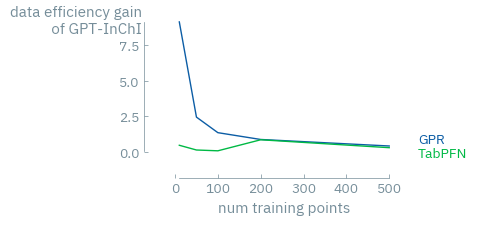

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(grouped_res.loc[5, "inchi", :].index, intersections, label="GPR")
ax.plot(grouped_res.loc[5, "inchi", :].index, intersections_tabpfn, label="TabPFN")

add_kappa_vlines(
    grouped_res.loc[5, "inchi", :]["kappa"].index,
    grouped_res.loc[5, "inchi", :]["kappa"]["mean"],
    low=-5,
    ymax=5,
)
ylabel_top("data efficiency gain\n  of GPT-InChI", x_pad=0.045, y_pad=-0.15)
ax.set_xlabel("num training points", labelpad=4)
range_frame(
    ax,
    grouped_res.loc[5, "inchi", :]["kappa"].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)
matplotx.line_labels(ax=ax)
plt.savefig("lipophilicity-5-data-efficiency.pdf", bbox_inches="tight")